In [21]:
#necessary libraries
import os
import math
import numpy as np
import itertools
import scipy
import sys
import time
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F


from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image, make_grid

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.autograd as autograd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

import glob
import random
from PIL import Image

In [22]:
num_gpus = torch.cuda.device_count()
num_gpus

2

In [41]:
# HYPERPARAMETERS
EPOCHS = 200
DATASET_TRAIN_MODE = "train"
DATASET_TEST_MODE = 'test'
BATCH_SIZE = 4
LR = 0.0002
DECAY_START_EPOCH = 100
BETA1 = 0.5
BETA2 = 0.999
IMG_SIZE = 128
CHANNELS = 3
N_CRTIC = 5
SAMPLE_INTERVAL = 100
NUM_RESIDUAL_BLOCKS = 19
LAMBDA_CYC = 10.0
LAMBDA_ID = 5.0

root_path = "/kaggle/input/summer2winter-yosemite"

In [42]:
def convert_to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image


class ImageDataset(Dataset):
    def __init__(self, root, transform=None, unaligned=False, mode="train"):
        self.root = root
        self.transform = transform
        self.unaligned = unaligned
        
        self.files_A = sorted(glob.glob(os.path.join(self.root, f"{mode}A") + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(self.root, f"{mode}B") + "/*.*"))
        '''
        ['/kaggle/input/summer2winter-yosemite/trainA/2009-12-06 06_58_39.jpg',
         '/kaggle/input/summer2winter-yosemite/trainA/2009-12-24 12_09_12.jpg'...
        '''
        
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
    
    def __getitem__(self, idx):
        image_A = Image.open(self.files_A[idx % len(self.files_A)])
        
        if self.unaligned:
            image_B = Image.open(random.randint(0, len(self.files_B)-1))
        else:
            image_B = Image.open(self.files_B[idx % len(self.files_B)])
            
            
        if image_A.mode != 'RGB':
            image_A = convert_to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = convert_to_rgb(image_B)
            
        if self.transform:
            image_A = self.transform(image_A)
            image_B = self.transform(image_B)
        
        return {
            'A': image_A,
            'B': image_B
        }

In [43]:
#image visulization

'''
PyTorch: image format C x H x W
PILLow and Matplotlib: image format H x W x C
'''
#function to show torch images
def show_image(img, size=10):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(size,size))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

import matplotlib.image as mpimg
def plot_output(path, x,y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)
    plt.show()

In [44]:
#transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation = Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
#train loader
train_dataloader = DataLoader(
    ImageDataset(root_path, transform, unaligned=False, mode=DATASET_TRAIN_MODE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_gpus
)
# next(iter(train_dataloader))['A'].size()
#val loader
val_dataloader = DataLoader(
    ImageDataset(root_path, transform, unaligned=False, mode=DATASET_TEST_MODE),
    batch_size = BATCH_SIZE**2,
    shuffle=True,
    num_workers=num_gpus
)
# next(iter(val_dataloader))['A'].data

In [45]:
# show_image(ImageDataset(root_path, transform, unaligned=False, mode=DATASET_TRAIN_MODE)[0]['A'])

In [46]:
#replay buffer
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty Buffer"
        self.max_size = max_size
        self.data = []
        
    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = element.unsqueeze(0)
            
            if len(self.data)  < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
            return torch.cat(to_return)
                    
''' torch.cat: Concatenates the given sequence of seq tensors in the given dimension. The consequence is that a specific dimension changes size e.g. dim=0 then you are adding elements to the row which increases the dimensionality of the column space. '''


' torch.cat: Concatenates the given sequence of seq tensors in the given dimension. The consequence is that a specific dimension changes size e.g. dim=0 then you are adding elements to the row which increases the dimensionality of the column space. '

In [47]:
'''
As per the paper - We keep the same learning rate for the first 100 epochs and 
linearly decay the rate to zero over the next 100 epochs.
'''
#using lr scheduler is like lr = initial_lr * function(epoch)
#we are going to build that function only

class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
    
    def step(self):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)


In [48]:
# Initialize convolution layer weights to N(mean=0,std=0.02)
def initialize_conv_weights_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [49]:
# residual block with two convolutional layer
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Reflection padding is used because it gives better image quality at edges.
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(1)
        )
        
    def forward(self, x):
        return x + self.block(x)
    
# res = ResidualBlock(256)
# res(torch.randn(256, 32, 32)).size()
# input => output => 3x128x128

In [50]:
# generator
'''
"c7s1-64,d128,d256,R256,R256,R256, R256,R256,R256,R256,R256,R256,u128 u64,c7s1-3"
'''

class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super().__init__()
        channels = input_shape[0]
        out_channels = 64
        
        model = [
            nn.ReflectionPad2d(channels), #3x134x134
            nn.Conv2d(channels, out_channels, 7, stride=1), #64x128x128
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace = True)
        ]
        in_channels = out_channels
        #64           #64
        
        #down sampling
        #d128 => d256
        #  input
        #64x128x128 => 128x64x64 => 256x32x32
        for _ in range(2):
            out_channels *= 2
            model += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
        
        """ Residual blocks - Per Paper
        R256,R256,R256,R256,R256,R256,R256,R256,R256
        """
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(in_channels)]
            
    
        # Upsampling
        # u128 => u64
        #128x32x32 => 64x64x64
        for _ in range(2):
            out_channels //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
            
        #output => 
        #output layer
        
        model += [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(in_channels, channels,  7),
            nn.Tanh()
        ]
        
       
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)
    
# gen = GeneratorResNet((3,128,128), 3)
# gen(torch.randn(1, 3,128,128)).size()

In [51]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self,input_shape):
        super().__init__()
        
        channels, height, width = input_shape
        output_shape = (1, height//2**4, width//2**4)
        
        def discriminator_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(num_features=out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            
            return layers
        
        # C64 -> C128 -> C256 -> C512
        self.model = nn.Sequential(
            *discriminator_block(channels, out_channels=64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            
        )
        
    def forward(self, x):
        x = self.model(x)
        self.output_shape = x.size()
        return x
        
# dis = Discriminator((3, 128, 128))
# dis(torch.randn(1,3,128,128))

# #discriminator output shape
# torch.Size([1, 1, 8, 8])

In [52]:
# setup loss and initialize models and buffer

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using {device} device")
    
#loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

input_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)

Gen_AB = GeneratorResNet(input_shape, NUM_RESIDUAL_BLOCKS)
Gen_BA = GeneratorResNet(input_shape, NUM_RESIDUAL_BLOCKS)
Disc_A = Discriminator(input_shape)
Disc_B = Discriminator(input_shape)

Gen_AB.to(device)
Gen_BA.to(device)
Disc_A.to(device)
Disc_B.to(device)
criterion_GAN.to(device)
criterion_cycle.to(device)
criterion_identity.to(device)

Gen_AB = nn.DataParallel(Gen_AB, device_ids=[0,1])
Gen_BA = nn.DataParallel(Gen_BA, device_ids=[0,1])
Disc_A = nn.DataParallel(Disc_A, device_ids=[0,1])
Disc_B = nn.DataParallel(Disc_B, device_ids=[0,1])

# Initialize weights
Gen_AB.apply(initialize_conv_weights_normal)
Gen_BA.apply(initialize_conv_weights_normal)
Disc_A.apply(initialize_conv_weights_normal)
Disc_B.apply(initialize_conv_weights_normal)

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

Using cuda device


In [53]:
# saving images
def save_img_samples(batches_done):
    """Saves a generated sample from the test set"""
    print('batches_done ', batches_done)
    imgs = next(iter(val_dataloader))
    Gen_AB.eval()
    Gen_BA.eval()
    real_A = imgs["A"].to(device)
    fake_B = Gen_AB(real_A)
    real_B = imgs["B"].to(device)
    fake_A = Gen_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=16, normalize=True)
    real_B = make_grid(real_B, nrow=16, normalize=True)
    fake_A = make_grid(fake_A, nrow=16, normalize=True)
    fake_B = make_grid(fake_B, nrow=16, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).to('cpu')   
#     path =  root_path + "/%s.png" % (batches_done)    # Path when running in Google Colab
    path =  '/kaggle/working' + "/%s.png" % (batches_done)    # Path when running inside Kaggle
    save_image(image_grid, path, normalize=False)    
    return path

In [54]:
# save_img_samples(4)

In [55]:
# plot_output('/kaggle/working/4.png', 10,10)

In [56]:
# optimizers
optimizer_G_AB =  torch.optim.Adam(
    Gen_AB.parameters(),
    lr = LR,
    betas = (BETA1, BETA2)
)
optimizer_G_BA =  torch.optim.Adam(
    Gen_BA.parameters(),
    lr = LR,
    betas = (BETA1, BETA2)
)
optimizer_Disc_A =  torch.optim.Adam(
    Disc_A.parameters(),
    lr = LR,
    betas = (BETA1, BETA2)
)
optimizer_Disc_B =  torch.optim.Adam(
    Disc_B.parameters(),
    lr = LR,
    betas = (BETA1, BETA2)
)

In [57]:
# training
def train(
    Gen_BA,
    Gen_AB,
    Disc_A,
    Disc_B,
    train_dataloader,
    n_epochs,
    criterion_identity,
    criterion_cycle,
    lambda_cyc,
    criterion_GAN,
    optimizer_G_AB,
    optimizer_G_BA,
    fake_A_buffer,
    fake_B_buffer,
    clear_output,
    optimizer_Disc_A,
    optimizer_Disc_B,
    device,
    sample_interval,
    lambda_id,
):
    prev_time = time.time()
    for epoch in range(1, n_epochs+1):
        for idx, batch in enumerate(train_dataloader):
            real_A = batch['A'].to(device)
            real_B = batch['B'].to(device)
            
            real = torch.ones((real_A.size(0), 1, 8, 8)).to(device)
            fake = torch.zeros((real_A.size(0), 1, 8, 8)).to(device)
            
            # train generators
            Gen_AB.train() # Gen_AB(real_A) will take real_A and produce fake_B
            Gen_BA.train() # Gen_BA(real_B) will take real_B and produce fake_A
            
            optimizer_G_AB.zero_grad()
            optimizer_G_BA.zero_grad()
            
            # identity loss
            loss_id_A = criterion_identity(Gen_BA(real_A), real_A)
            loss_id_B = criterion_identity(Gen_AB(real_B), real_B)
            
            loss_identity = (loss_id_A + loss_id_B) / 2
            
            #gan losses
            fake_A = Gen_BA(real_B)
            fake_B = Gen_AB(real_A)
            
            loss_GAN_AB = criterion_GAN(Disc_B(fake_B), real)
            loss_GAN_BA = criterion_GAN(Disc_A(fake_A), real)
            
            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
            
            #cyclic loss
            reconstructed_A = Gen_BA(fake_B)
            reconstructed_B = Gen_AB(fake_A)
            
            loss_cycle_A = criterion_cycle(reconstructed_A, real_A)
            loss_cycle_B = criterion_cycle(reconstructed_B, real_B)
            
            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
            
            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
            loss_G.backward()
            optimizer_G_AB.step()
            optimizer_G_BA.step()
            
            #train discriminator A
            optimizer_Disc_A.zero_grad()
            loss_real = criterion_GAN(Disc_A(real_A), real)
            
            # Fake loss (on batch of previously generated samples)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(Disc_A(fake_A_.detach()), fake)
            loss_Disc_A = (loss_real + loss_fake) / 2
            loss_Disc_A.backward()
            optimizer_Disc_A.step()
            
                                      
            #training discriminator B
            optimizer_Disc_B.zero_grad()
            loss_real = criterion_GAN(Disc_B(real_B), real)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(Disc_B(fake_B_.detach()), fake)
            loss_Disc_B = (loss_real + loss_fake)/2
            loss_Disc_B.backward()
            optimizer_Disc_B.step()
                                      
                                      
            loss_D = (loss_Disc_A + loss_Disc_B) / 2
                                      
            
            #log process
            batches_done = epoch * len(train_dataloader) + idx
            batches_left = n_epochs * len(train_dataloader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time)
            )
            prev_time = time.time()
            print(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                % (
                    epoch,
                    n_epochs,
                    idx,
                    len(train_dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    loss_cycle.item(),
                    loss_identity.item(),
                    time_left,
                )
            )
            # If at sample interval save image
            if batches_done % sample_interval == 0:
                clear_output()
                plot_output(save_img_samples(batches_done), 30, 40)
                                      
                                      

batches_done  400


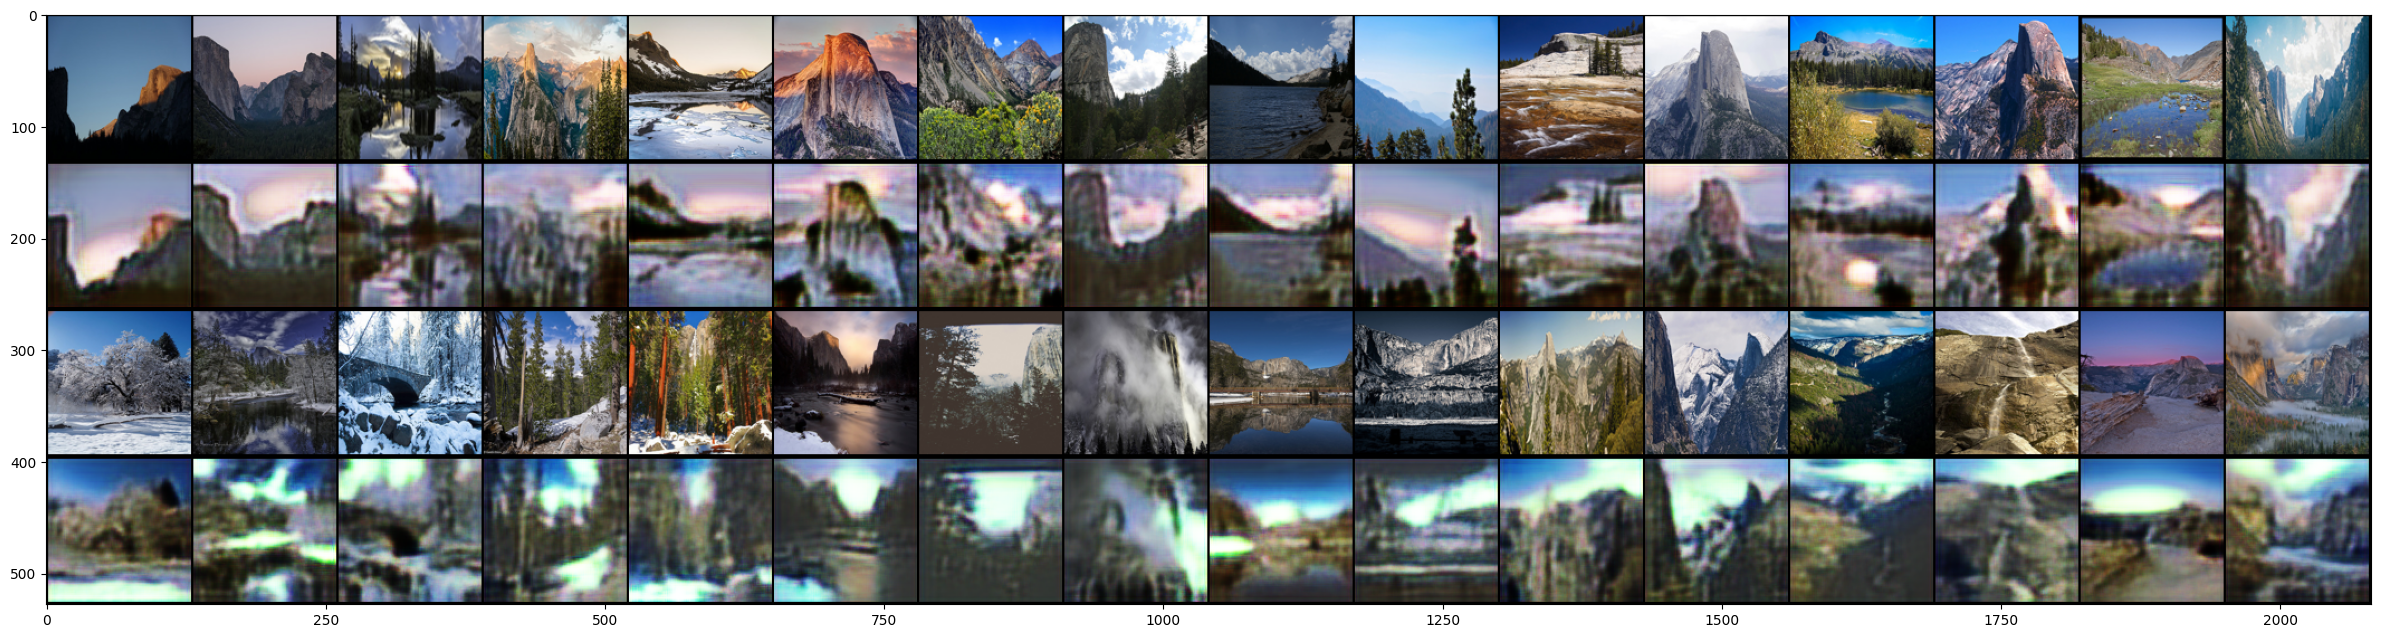

[Epoch 1/200] [Batch 93/308] [D loss: 0.292377] [G loss: 3.573978, adv: 0.367724, cycle: 0.218476, identity: 0.204299] ETA: 2 days, 14:41:53.246973
[Epoch 1/200] [Batch 94/308] [D loss: 0.249860] [G loss: 4.383885, adv: 0.400040, cycle: 0.277335, identity: 0.242099] ETA: 12:54:25.364848
[Epoch 1/200] [Batch 95/308] [D loss: 0.363382] [G loss: 3.721143, adv: 0.284026, cycle: 0.237470, identity: 0.212483] ETA: 13:01:45.822359
[Epoch 1/200] [Batch 96/308] [D loss: 0.279015] [G loss: 4.122430, adv: 0.408721, cycle: 0.260987, identity: 0.220769] ETA: 13:37:09.923482
[Epoch 1/200] [Batch 97/308] [D loss: 0.354698] [G loss: 4.056793, adv: 0.441783, cycle: 0.250449, identity: 0.222103] ETA: 13:57:31.211957
[Epoch 1/200] [Batch 98/308] [D loss: 0.280943] [G loss: 4.986326, adv: 0.365110, cycle: 0.324149, identity: 0.275944] ETA: 12:58:18.405132
[Epoch 1/200] [Batch 99/308] [D loss: 0.346811] [G loss: 4.360139, adv: 0.355147, cycle: 0.274994, identity: 0.251010] ETA: 12:53:58.983913
[Epoch 1/200

KeyboardInterrupt: 

In [58]:
train(
    Gen_BA = Gen_BA,
    Gen_AB = Gen_AB,
    Disc_A = Disc_A,
    Disc_B = Disc_B,
    train_dataloader = train_dataloader,
    n_epochs = EPOCHS,
    criterion_identity = criterion_identity,
    criterion_cycle = criterion_cycle,
    lambda_cyc = LAMBDA_CYC,
    criterion_GAN = criterion_GAN,
    optimizer_G_AB = optimizer_G_AB,
    optimizer_G_BA = optimizer_G_BA,
    fake_A_buffer = fake_A_buffer,
    fake_B_buffer = fake_B_buffer,
    clear_output = clear_output,
    optimizer_Disc_A = optimizer_Disc_A,
    optimizer_Disc_B = optimizer_Disc_B,
    device = device,
    sample_interval = SAMPLE_INTERVAL,
    lambda_id = LAMBDA_ID,
)